<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/dll_hw_8_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import random
import re
import string
from   itertools import product
import unicodedata

import torch
import torch.nn as nn
from   torch import optim
import torch.nn.functional as F

import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
plt.switch_backend('agg')

### 2. Импорт и предобработка текста

In [3]:
!tail rus-eng/rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

In [4]:
SOS_token = 0
EOS_token = 1

lang1 = 'eng'
lang2 = 'rus'


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    return s

In [9]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open('rus-eng/rus.txt', encoding='utf-8').read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    for p in pairs:
        del p[2]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p, prefi, max_):
    if prefi == None:
        return  len(p[0].split(' ')) >3 and \
                len(p[1].split(' ')) >3 and \
                len(p[0].split(' ')) < max_ and \
                len(p[1].split(' ')) < max_ 
    else:
        return  len(p[0].split(' ')) >3 and \
                len(p[1].split(' ')) >3 and \
                len(p[0].split(' ')) < max_ and \
                len(p[1].split(' ')) < max_ and \
                p[1].startswith(eng_prefixes)

def filterPairs(pairs, pref, max_l):
    return [pair for pair in pairs if filterPair(pair, pref, max_l)]

In [11]:
def prepareData(lang1, lang2, pre, max_le,  reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, pre, max_le)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', None, 20, True)
print(random.choice(pairs))

Reading lines...


Read 487600 sentence pairs
Trimmed to 463867 sentence pairs
Counting words...
Counted words:
rus 55846
eng 16652
['мы так и не узнали кто был тот человек .', 'we never found out who that man was .']


In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, input_l, output_l):
    input_tensor = tensorFromSentence(input_l, pair[0])
    target_tensor = tensorFromSentence(output_l, pair[1])
    return (input_tensor, target_tensor)

### 3. Архитектура сети

#### 3.1. Encoder




In [13]:
class EncoderRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type):
        super(EncoderRNN2, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = rnn_type(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### 3.2. Decoder - 1

In [14]:
class AttnDecoderRNN_mlp(nn.Module): 
    def __init__(
        self, 
        hidden_size, 
        output_size, 
        rnn_type, 
        m_length,
        dropout_p=0.1
    ):
        super(AttnDecoderRNN_mlp, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p   = dropout_p
        self.max_length  = m_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine= nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.rnn_t_n = rnn_type.__name__

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        if self.rnn_t_n == 'LSTM':
            attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        else:
            attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1) 
             
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### 3.3. Decoder - 2

In [15]:
class AttnDecoderRNN_scalar(nn.Module):
    def __init__(
        self, 
        hidden_size, 
        output_size, 
        rnn_type, 
        m_length,
        dropout_p=0.1
    ):
        super(AttnDecoderRNN_scalar, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = m_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.rnn_t_n = rnn_type.__name__

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax((embedded[0] @ encoder_outputs.T) / self.max_length**0.5, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### 3.4. Train + Teacher forcing

In [16]:
def train(
    input_tens, 
    target_tens, 
    encode, 
    decode, 
    encode_optimizer, 
    decode_optimizer, 
    criteri, 
    m__length, 
    rnn_ty,  
    t_f_ratio
):
    if rnn_ty.__name__ == 'LSTM':
        encoder_hidden = (encode.initHidden(), encode.initHidden())
    else:
        encoder_hidden = encode.initHidden()

    encode_optimizer.zero_grad()
    decode_optimizer.zero_grad()

    input_length = input_tens.size(0)
    target_length = target_tens.size(0)

    encoder_outputs = torch.zeros(m__length, encode.hidden_size, device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encode(input_tens[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < t_f_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decode(decoder_input, decoder_hidden, encoder_outputs)
            loss += criteri(decoder_output, target_tens[di])
            decoder_input = target_tens[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decode(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criteri(decoder_output, target_tens[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encode_optimizer.step()
    decode_optimizer.step()

    return loss.item() / target_length

#### 3.5. Train + iters

In [17]:
def trainIters(pair_sentenses, encoder, decoder, learning_rate, 
               n_iters, MAX_LENGTH, rnn_typ, teach_f_ratio, input_lan, output_lan,
               print_every=5000, plot_every=500):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    print_loss_avg=0
    print_loss_total_abs=0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pair_sentenses), 
                                      input_lan, output_lan)
                                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion, 
                     MAX_LENGTH, rnn_typ,  teach_f_ratio)
        print_loss_total += loss
        plot_loss_total  += loss
        print_loss_total_abs += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return print_loss_avg

#### 3.6. Evaluate

In [18]:
def evaluate(encode, decode, sentence, max_length, Rnn, inp_lang, out_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(inp_lang, sentence)
        input_length = input_tensor.size()[0]

        if Rnn.__name__ == 'LSTM':
            encoder_hidden = (encode.initHidden(), encode.initHidden())
        else:
            encoder_hidden = encode.initHidden()

        encoder_outputs = torch.zeros(max_length, encode.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encode(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decode(
                                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(out_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(pair_sen, encoder, decoder, MAX_LENGTH, 
                     rnn_, in_lang, o_lang,  n=10):
    for i in range(n):
        pair = random.choice(pair_sen)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0], MAX_LENGTH,  # output_words, attentions
                                            rnn_, in_lang, o_lang)[0]
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### 3.7. Вспомогательные функции

In [20]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [21]:
def fine_table(table, title = None, x_l=None, y_l = None):
    p_t = table
    fig, ax = plt.subplots(figsize=(12,4))
    sns.heatmap(p_t, 
                annot = True, 
                fmt ='.3', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black'
                )
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.xlabel(x_l)
    plt.ylabel(y_l)
    plt.title(title)
    i, k = ax.get_ylim()
    ax.set_ylim(i+0.5, k-0.5)
    plt.show()

### 4. Обучение 

In [22]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

rnn_types = [nn.LSTM, nn.RNN, nn.GRU] 
cols = ['Max_length', 'RNN_Type', 'Hidden_layers', 'Decoder', 'Loss']

PATH8 = 'df__8__'

In [23]:
def test_model_hw_8(max_length_sent, prefix, hidden_size = 256,
                    learn_rate = 0.01, 
                    teach_force_ratio = 0.5, 
                    num_iters = 50000,  every = 1000, num_file = 999):
    
    input_lang_, output_lang_, pair_s = prepareData('eng', 'rus', prefix, max_length_sent, True)
    
    print(random.choice(pair_s))
    
    df = pd.DataFrame(columns= cols)

    for rnn_type, decoder_ in product(rnn_types, range(2)):
        print('\nMax_length = ', max_length_sent)
        print('\nDecoder = ', decoder_ + 1)
        print(f'{rnn_type.__name__}\n\ntraining')

        encoder2 = EncoderRNN2(input_lang_.n_words, hidden_size, rnn_type).to(device)

        att_dec_mllp  = AttnDecoderRNN_mlp(
            hidden_size, 
            output_lang_.n_words, 
            rnn_type, 
            max_length_sent,dropout_p=0.1
        ).to(device)
        
        att_dec_scalar = AttnDecoderRNN_scalar(
            hidden_size, output_lang_.n_words, 
            rnn_type, 
            max_length_sent, dropout_p=0.1
        ).to(device)

        d_list = [att_dec_mllp, att_dec_scalar]
        d_text = str(d_list[decoder_])

        loss_= trainIters(
            pair_s, 
            encoder2, 
            d_list[decoder_], 
            learn_rate, 
            num_iters, 
            max_length_sent,  
            rnn_type, 
            teach_force_ratio, 
            input_lang_, 
            output_lang_, 
            every
        )
        print('\nevaluate\n')
        evaluateRandomly(
            pair_s, 
            encoder2, 
            d_list[decoder_], 
            max_length_sent, 
            rnn_type, 
            input_lang_, 
            output_lang_
        )

        string = [max_length_sent, rnn_type.__name__, 0, d_text, loss_]
        df.loc[len(df)] = string
        file_name  = PATH8 + str(num_file) + '.csv'
        df.to_csv(file_name)

#### 4.1.  Модель 1 - Предложения по шаблону eng_prefixes от 3 до 20 слов / lr = 0.05

In [ ]:
test_model_hw_8(
    max_length_sent = 20, 
    prefix = eng_prefixes, 
    learn_rate = 0.05, 
    teach_force_ratio = 0.5,
    num_iters = 75000,
    every = 5000, 
    num_file = 'Att1'
)

In [ ]:
dec= ['mlp', 'scalar']*3
dec

In [ ]:
exp1 = pd.read_csv(PATH8+'Att1.csv').iloc[:,[1,2,4,5]]
exp1['Decoder'] = dec
exp1['learn_rate']= 0.05
exp1 = exp1.iloc[:,[-1,0,1,2,3]]
exp1

#### 4.2.  Модель 2 - Предложения длиной от 3 до до 7 слов все / без привязки к шаблону / lr = 0.05

In [ ]:
test_model_hw_8(
    max_length_sent = 7, 
    prefix = None,
    learn_rate = 0.05, 
    teach_force_ratio = 0.5, 
    num_iters = 75000,  
    every = 5000, 
    num_file ='Att2'
)

In [ ]:
exp2 = pd.read_csv(PATH8+'Att2.csv').iloc[:,[1,2,4,5]]
exp2['Decoder'] = dec[:4]
exp2['learn_rate']= 0.05
exp2 = exp2.iloc[:,[-1,0,1,2,3]]
exp2

#### 4.3.  Модель 3 - Предложения длиной от 3 до 20 слов все / без привязки к шаблону  / lr = 0.05

In [ ]:
test_model_hw_8(
    max_length_sent = 20, 
    prefix = None,
    learn_rate = 0.05, 
    teach_force_ratio = 0.5, 
    num_iters = 75000,  
    every = 5000, 
    num_file ='Att3'
)

In [ ]:
exp3 = pd.read_csv(PATH8+'Att3.csv').iloc[:,[1,2,4,5]]
exp3['Decoder'] = dec[:4]
exp3['learn_rate']= 0.05
exp3 = exp3.iloc[:,[-1,0,1,2,3]]
exp3

#### 4.4.  Модель 4 - Предложения длиной от 3 до 20 слов все / без привязки к шаблону / lr = 0.001

In [ ]:
test_model_hw_8(
    max_length_sent = 20, 
    prefix = None,
    learn_rate = 0.001, 
    teach_force_ratio = 0.5, 
    num_iters = 75000,  
    every = 5000, 
    num_file ='Att5'
)

In [ ]:
exp4 = pd.read_csv(PATH8+'Att5.csv').iloc[:,[1,2,4,5]]
exp4['Decoder'] = dec[:4]
exp4['learn_rate'] = 0.001
exp4 = exp4.iloc[:,[-1,0,1,2,3]]
exp4

#### 4.5.  Модель 5 - Предложения длиной от 3 до 20 слов все / без привязки к шаблону / lr = 0.003

In [ ]:
test_model_hw_8(
    max_length_sent = 20, 
    prefix = None,
    learn_rate = 0.003, 
    teach_force_ratio = 0.5, 
    num_iters = 75000,  
    every = 5000, 
    num_file ='Att6'
)

In [ ]:
exp5 = pd.read_csv(PATH8+'Att6.csv').iloc[:,[1,2,4,5]]
exp5['Decoder'] = dec[:4]
exp5['learn_rate'] = 0.003
exp5 = exp5.iloc[:,[-1,0,1,2,3]]
exp5

#### 4.6.  Модель 6 - Предложения длиной от 1 до 20 слов / без привязки к шаблону / lr = 0.003

In [ ]:
#  убираем фильтр до 3 слов
test_model_hw_8(
    max_length_sent = 20, 
    prefix = None,
    learn_rate = 0.003, 
    teach_force_ratio = 0.5, 
    num_iters = 75000,  
    every = 5000, 
    num_file ='Att7'
)

In [ ]:
exp6 = pd.read_csv(PATH8+'Att7.csv').iloc[:,[1,2,4,5]]
exp6['Decoder'] = dec[:4]
exp6['learn_rate'] = 0.003
exp6 = exp6.iloc[:,[-1,0,1,2,3]]
exp6

### 5. Обобщение результатов экспериментов

In [22]:
results = pd.concat([exp1, exp2, exp3, exp4, exp5, exp6]).reset_index(drop=True)
results

,learn_rate,Max_length,RNN_Type,Decoder,Loss
0,0.050,20,LSTM,mlp,1.630128
1,0.050,20,LSTM,scalar,1.684131
2,0.050,20,RNN,mlp,24.655075
3,0.050,20,RNN,scalar,17.377365
4,0.050,20,GRU,mlp,22.233171
5,0.050,20,GRU,scalar,3.147843
6,0.050,7,LSTM,mlp,2.374869
7,0.050,7,LSTM,scalar,2.324447
8,0.050,7,GRU,mlp,19.445005
9,0.050,7,GRU,scalar,15.190802


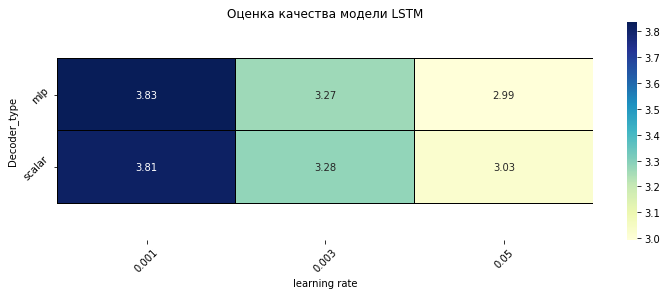

In [ ]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)&
                     (results.RNN_Type=='LSTM')]

fine_table(
    pd.pivot_table(
        temp_table,
        values  = 'Loss',
        columns = 'learn_rate',
        index   = 'Decoder',
        aggfunc = 'max'
    ), 
    title = 'Оценка качества модели LSTM', 
    x_l='learning rate', 
    y_l = 'Decoder_type')  

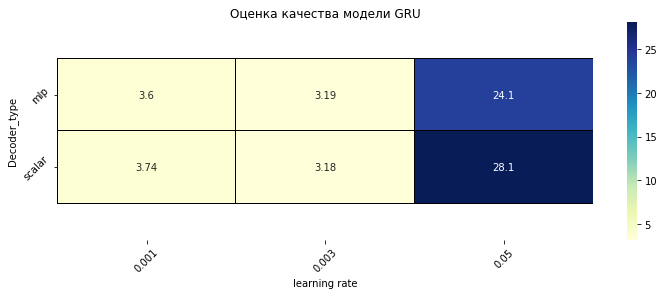

In [ ]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)&
                     (results.RNN_Type=='GRU')]

fine_table(
    pd.pivot_table(
        temp_table,
        values  = 'Loss',
        columns = 'learn_rate',
        index   = 'Decoder',
        aggfunc = 'max'
    ), 
    title = 'Оценка качества модели GRU', 
    x_l='learning rate', 
    y_l = 'Decoder_type')

In [20]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)]

fine_table(
    pd.pivot_table(
        temp_table,
        values  = 'Loss',
        columns = 'Decoder',
        index   = ['RNN_Type', 'learn_rate'],
        aggfunc = 'max'
    ), 
    title = 'Оценка качества модели от типа декодера Attention', 
    x_l='Decoder_type', 
    y_l = 'RNN / learning rate')

In [21]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)]

fine_table(
    pd.pivot_table(
        temp_table,
        values  = 'Loss',
        columns = 'Decoder',
        index   = ['RNN_Type', 'learn_rate'],
        aggfunc = 'max'
    ), 
    title = 'Оценка качества модели от типа декодера Attention', 
    x_l='Decoder_type', 
    y_l = 'RNN / learning rate')

In [39]:
temp_table = results[(results.index>1)&
                     (results.index<22)&
                     (results.Max_length==20)]
temp_table.head(1)

,learn_rate,Max_length,RNN_Type,Decoder,Loss
2,0.05,20,RNN,mlp,24.655075


In [32]:
fine_table(
    pd.pivot_table(
        temp_table,
        values = 'Loss',
        columns = 'Decoder',
        index = ['RNN_Type', 'learn_rate'],
        aggfunc = 'max'
    ), 
    title = 'Оценка качества модели от типа декодера Attention', 
    x_l='Decoder_type', 
    y_l = 'RNN / learning rate')

In [38]:
pp = pd.pivot_table(
   temp_table,
   values  = 'Loss',
   columns = 'Decoder',
   index   = ['RNN_Type', 'learn_rate'],
   aggfunc = 'max'
)
pp

Decoder                    mlp     scalar
RNN_Type learn_rate                      
GRU      0.001        3.600392   3.739083
         0.003        3.185217   3.181635
         0.050       24.058059  28.091668
LSTM     0.001        3.834810   3.813181
         0.003        3.265885   3.280422
         0.050        2.994014   3.025424
RNN      0.050       24.655075  17.377365